In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import needed packages
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
from tensorflow import keras
from tensorflow.keras import models, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import DirectoryIterator
from tensorflow.keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
from keras import optimizers
from datetime import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
main_path = '/content/gdrive/My Drive/Thesis/Data/COVID-classification/'
train_path_org = main_path+'train/'
test_path_org = main_path+'test/'
val_path_org = main_path+'val/'

In [ ]:
train_path_mask = main_path+'train_masks/'
test_path_mask = main_path+'test_masks/'
val_path_mask = main_path+'val_masks/'

In [ ]:
#Loading the ResNet-50 model to test original model

res = ResNet50(include_top=False, weights='imagenet' ,input_shape=(512, 512, 3))

for layer in res.layers:
  layer.trainable = False

x = Flatten()(res.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
pred = Dense(1, activation='sigmoid')(x)

model = keras.Model(res.input, pred)


# summarize the model
#model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
adam = optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

In [ ]:
train_set = DirectoryIterator(train_path_org,
                            datagen,
                            target_size = (512, 512),
                            batch_size = 32,
                            class_mode = 'binary',
                            shuffle = True)

Found 7070 images belonging to 2 classes.


In [ ]:
train_set_mask = DirectoryIterator(train_path_mask,
                            datagen,
                            target_size = (512, 512),
                            batch_size = 32,
                            class_mode = 'binary',
                            shuffle = True)

Found 7070 images belonging to 2 classes.


In [ ]:
val_set = DirectoryIterator(val_path_org,
                            datagen,
                            target_size = (512, 512),
                            batch_size = 32,
                            class_mode = 'binary',
                            shuffle = True)

Found 786 images belonging to 2 classes.


In [ ]:
val_set_mask = DirectoryIterator(val_path_mask,
                            datagen,
                            target_size = (512, 512),
                            batch_size = 32,
                            class_mode = 'binary',
                            shuffle = True)

Found 786 images belonging to 2 classes.


In [ ]:
test_set = DirectoryIterator(test_path_org,
                            datagen,
                            target_size = (512, 512),
                            batch_size = 32,
                            class_mode = 'binary',
                            shuffle = False)

Found 1965 images belonging to 2 classes.


In [ ]:
test_set_mask = DirectoryIterator(test_path_mask,
                            datagen,
                            target_size = (512, 512),
                            batch_size = 32,
                            class_mode = 'binary',
                            shuffle = False)

Found 1965 images belonging to 2 classes.


In [ ]:
# train model on original data
with tf.device('/device:GPU:0'):
  early = EarlyStopping(monitor='val_loss', patience=5)
  check = ModelCheckpoint('/content/gdrive/My Drive/Thesis/models/ResNet-1.h5', save_best_only=True, monitor='val_loss', mode='min')
  model_history=model.fit(
    train_set,
    validation_data=val_set,
    epochs=40,
    callbacks=[early,check],
    verbose=1)

Epoch 1/40
221/221 [==============================] - 2696s 12s/step - loss: 3.7326 - accuracy: 0.8819 - val_loss: 0.4120 - val_accuracy: 0.9720


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
221/221 [==============================] - 149s 675ms/step - loss: 0.5039 - accuracy: 0.9512 - val_loss: 0.1143 - val_accuracy: 0.9809
Epoch 3/40
221/221 [==============================] - 145s 656ms/step - loss: 0.2320 - accuracy: 0.9629 - val_loss: 0.2452 - val_accuracy: 0.9720
Epoch 4/40
221/221 [==============================] - 140s 634ms/step - loss: 0.1482 - accuracy: 0.9692 - val_loss: 0.1409 - val_accuracy: 0.9784
Epoch 5/40
221/221 [==============================] - 140s 632ms/step - loss: 0.0906 - accuracy: 0.9805 - val_loss: 0.1641 - val_accuracy: 0.9873
Epoch 6/40
221/221 [==============================] - 140s 632ms/step - loss: 0.1056 - accuracy: 0.9827 - val_loss: 0.1438 - val_accuracy: 0.9885
Epoch 7/40
221/221 [==============================] - 140s 632ms/step - loss: 0.0806 - accuracy: 0.9857 - val_loss: 0.0973 - val_accuracy: 0.9847
Epoch 8/40
221/221 [==============================] - 142s 638ms/step - loss: 0.0553 - accuracy: 0.9857 - val_loss: 0.1025 -

In [ ]:
y_pred = model.predict(test_set)

confusion_matrix(test_set.labels, y_pred.round())

array([[970,  13],
       [ 10, 972]])

In [ ]:
# original data
model.evaluate(test_set)

62/62 [==============================] - 35s 560ms/step - loss: 0.0351 - accuracy: 0.9883


[0.035065699368715286, 0.9882951378822327]

Now the same model will be trained on data that has been processed to have a mask over the image.

In [ ]:
#Loading the inceptionV3 model to test original model

resnet_masks = ResNet50(include_top=False, weights='imagenet' ,input_shape=(512, 512, 3))

for layer in resnet_masks.layers:
  layer.trainable = False

x = Flatten()(resnet_masks.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
pred = Dense(1, activation='sigmoid')(x)

model_masks = keras.Model(resnet_masks.input, pred)


# summarize the model
#model.summary()

In [ ]:
model_masks.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  early = EarlyStopping(monitor='val_loss', patience=5)
  check = ModelCheckpoint('/content/gdrive/My Drive/Thesis/models/ResNet_masks-1.h5', save_best_only=True, monitor='val_loss', mode='min')
  model_history_masks=model_masks.fit(
    train_set_mask,
    validation_data=val_set_mask,
    epochs=40,
    callbacks=[early,check],
    verbose=1)

Epoch 1/40
221/221 [==============================] - 2265s 10s/step - loss: 12.4519 - accuracy: 0.6140 - val_loss: 0.5313 - val_accuracy: 0.8193


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
221/221 [==============================] - 180s 815ms/step - loss: 0.6991 - accuracy: 0.7041 - val_loss: 0.5251 - val_accuracy: 0.8168
Epoch 3/40
221/221 [==============================] - 194s 879ms/step - loss: 0.6280 - accuracy: 0.7221 - val_loss: 0.4622 - val_accuracy: 0.8295
Epoch 4/40
221/221 [==============================] - 196s 885ms/step - loss: 0.5317 - accuracy: 0.7504 - val_loss: 0.4195 - val_accuracy: 0.8193
Epoch 5/40
221/221 [==============================] - 199s 899ms/step - loss: 0.4978 - accuracy: 0.7734 - val_loss: 0.4081 - val_accuracy: 0.8410
Epoch 6/40
221/221 [==============================] - 199s 900ms/step - loss: 0.4731 - accuracy: 0.7801 - val_loss: 0.3711 - val_accuracy: 0.8295
Epoch 7/40
221/221 [==============================] - 198s 897ms/step - loss: 0.4576 - accuracy: 0.7986 - val_loss: 0.3705 - val_accuracy: 0.8601
Epoch 8/40
221/221 [==============================] - 200s 903ms/step - loss: 0.4226 - accuracy: 0.8164 - val_loss: 0.3339 -

In [ ]:
y_pred_masks = model_masks.predict(test_set_mask)

confusion_matrix(test_set_mask.labels, y_pred_masks.round())

array([[875, 100],
       [105, 885]])

In [ ]:
# masked data
model_masks.evaluate(test_set_mask)

62/62 [==============================] - 33s 532ms/step - loss: 0.3728 - accuracy: 0.8957


[0.3728320598602295, 0.8956742882728577]

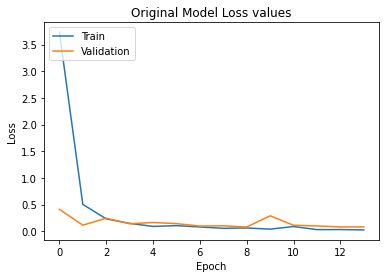

In [ ]:
# Plot train and validation accuracy of the model trained on original data
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Original Model Loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

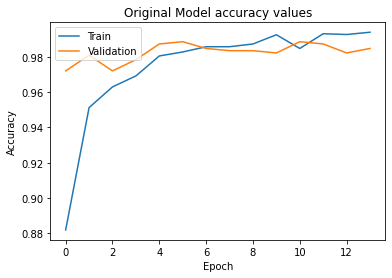

In [ ]:
# Plot train and validation accuracy of the model trained on masked data
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Original Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

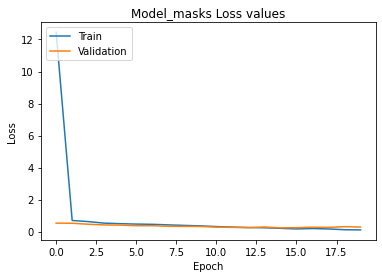

In [ ]:
# Plot train and validation accuracy of the model trained on masked data
plt.plot(model_history_masks.history['loss'])
plt.plot(model_history_masks.history['val_loss'])
plt.title('Model_masks Loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

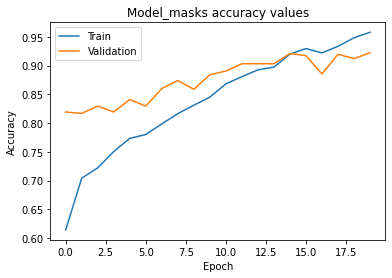

In [ ]:
# Plot train and validation accuracy of the model trained on masked data
plt.plot(model_history_masks.history['accuracy'])
plt.plot(model_history_masks.history['val_accuracy'])
plt.title('Model_masks accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()